Load the needed libraries

In [6]:
!pip install datasets transformers

In [7]:
!pip install torchinfo

In [8]:
from google.colab import drive

from torch import cuda
import os
from collections import Counter

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

from google.colab import files

In [9]:
# Mount Google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Detect and set hardware
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device}")

Using cuda


In [11]:
# Load the dataset
dataset = load_dataset("AlvaroVasquezAI/Animal_Image_Classification_Dataset")

# Define a path to save in Google Colab
#dataset_path = "/content/animal_image_dataset"

# Save one split of the dataset to disk (e.g., train)
#dataset['train'].save_to_disk(dataset_path)

#print(f"Dataset saved to: {dataset_path}")
print("Dataset downloaded successfully")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

cats_dogs_snakes.zip:   0%|          | 0.00/40.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Dataset downloaded successfully


In [12]:
# get the keys in dataset
all_keys = dataset.keys()
print(all_keys)

dict_keys(['train'])


In [13]:
# View the first sample description
print(dataset['train'][0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x782E71EB0290>, 'label': 0}


In [14]:
# Get class name for a label
label_id = dataset['train'][0]['label']
class_name = dataset['train'].features['label'].names[label_id]

print(f"Label {label_id} corresponds to class: {class_name}")

Label 0 corresponds to class: cats


In [15]:
# Get the mapping from label indices to class names
label_names = dataset["train"].features["label"].names

# Function to replace label index with class name
def map_label_to_name(images):
    images["label_name"] = label_names[images["label"]]
    return images

# Apply the function
dataset = dataset.map(map_label_to_name)

# Check the result
print(dataset["train"][0])

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x782D502D3950>, 'label': 0, 'label_name': 'cats'}


In [16]:
# New folder in Google Drive to store the dataset
base_dir = "/content/drive/My Drive/Multi-classAnimalDataset"

# Create the base folder
"""os.makedirs(base_dir, exist_ok=True)

# Loop through and save images
for idx, images in tqdm(enumerate(dataset["train"]), total=len(dataset["train"])):
    img = images["image"]
    label_name = images["label_name"]

    # Create a folder for the class
    label_folder = os.path.join(base_dir, label_name)
    os.makedirs(label_folder, exist_ok=True)

    # Save each image with a unique name
    img_path = os.path.join(label_folder, f"{label_name}_{idx}.jpg")
    img.save(img_path)"""
print(f"Images saved to {base_dir}")

Images saved to /content/drive/My Drive/Multi-classAnimalDataset


Data Preprocessing

In [17]:
tranform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [18]:
image_dataset = ImageFolder(root = base_dir, transform = tranform)
dataloader = DataLoader(image_dataset, batch_size = 32)

In [19]:
# List all class folders
print(f"Classes in dataset: {image_dataset.classes}")
print(f"We have {len(image_dataset.classes)} classes in our dataset")
print()
print("Tensor shape for one image:")
print(image_dataset[0][0].shape)

Classes in dataset: ['cats', 'dogs', 'snakes']
We have 3 classes in our dataset

Tensor shape for one image:
torch.Size([3, 224, 224])


In [20]:
# Get one batch
first_batch = next(iter(dataloader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


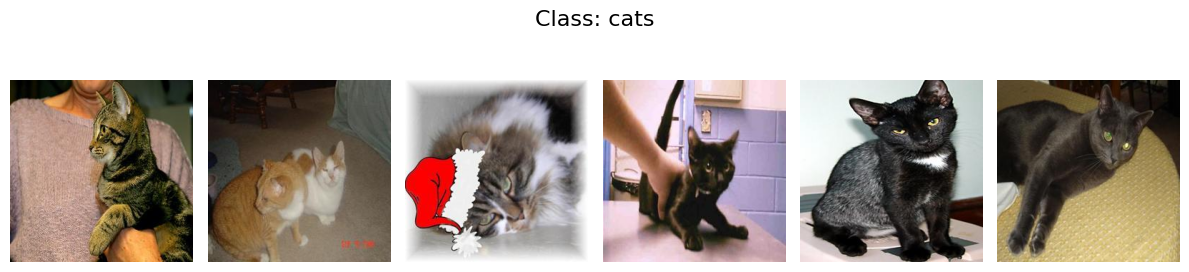

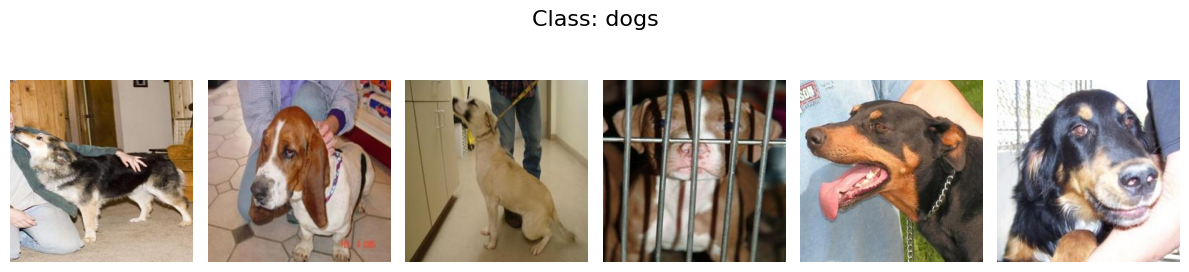

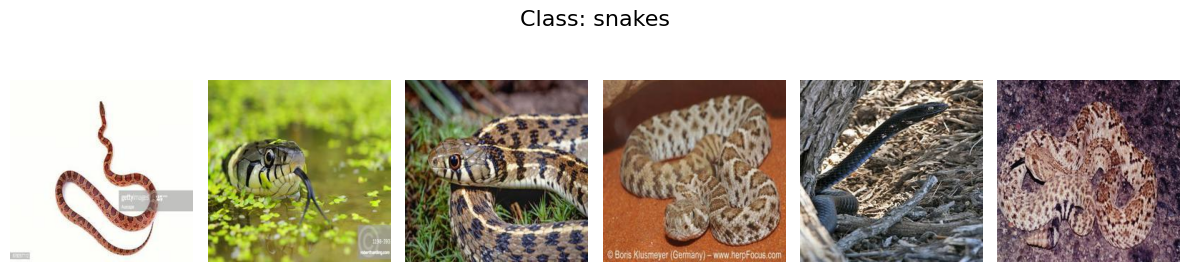

In [21]:
# Display 6 images per class
for class_name in image_dataset.classes:
    class_path = os.path.join(base_dir, class_name)
    image_files = sorted(os.listdir(class_path))[:6]  # First 6 images

    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Class: {class_name}", fontsize=16)

    for i, image_file in enumerate(image_files):
        img_path = os.path.join(class_path, image_file)
        img = Image.open(img_path)

        plt.subplot(1, 6, i+1)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [25]:
# Data Splitting
g = torch.Generator()
g.manual_seed(42)

train_data, val_data = random_split(image_dataset, [0.8, 0.2])

length_train = len(train_data)
length_val = len(val_data)
#length_test = len(test_data)
length_data = len(image_dataset)
training_percent = np.round(100 * length_train / length_data, 2)
val_percent = np.round(100 * length_val / length_data, 2)
#test_percent = np.round(100 * length_test / length_data, 2)

print(f"Train data is {training_percent}% of our data")
print(f"Validation data is {val_percent}% of our data")
#print(f"Test data is {test_percent}% of our data")

Train data is 80.0% of our data
Validation data is 20.0% of our data


  0%|          | 0/2400 [00:00<?, ?it/s]

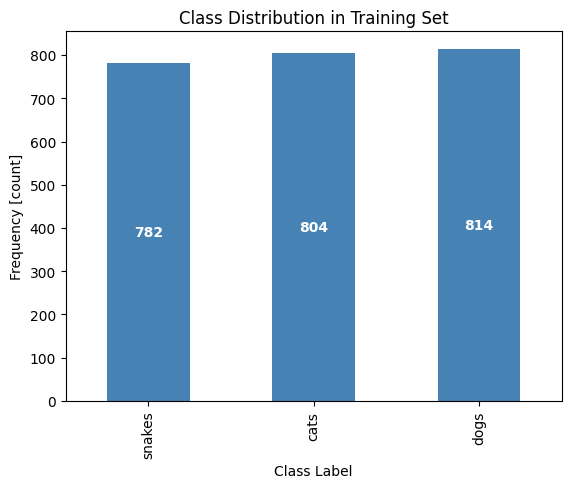

In [26]:
# Splitting distribution
def counts_class(data):
    c = Counter(x[1] for x in tqdm(data))
    class_to_index = data.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

# Calculate training_distributions
training_distributions = counts_class(train_data)

# Plot the training bar chart
ax = training_distributions.sort_values().plot(kind="bar", color='steelblue')

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Training Set")

# Overlay the value centered in each bar
for i, v in enumerate(training_distributions.sort_values()):
    bar = ax.patches[i]
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        v / 2,                              # Y position
        str(v),                             # Text
        color='white', fontweight='bold', ha='center', va='center'
    )

plt.show()

  0%|          | 0/600 [00:00<?, ?it/s]

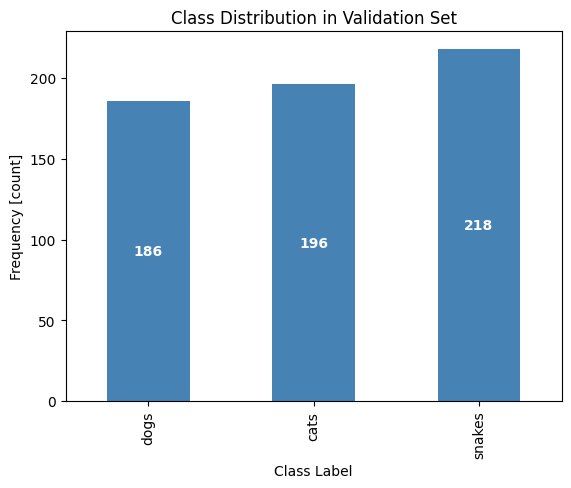

In [27]:
# Calculate val_distributions
val_distributions = counts_class(val_data)

# Plot the Validation bar chart
ax = val_distributions.sort_values().plot(kind="bar", color='steelblue')

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Validation Set")
# Overlay the value centered in each bar
for i, v in enumerate(val_distributions.sort_values()):
    bar = ax.patches[i]
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        v / 2,                              # Y position
        str(v),                             # Text
        color='white', fontweight='bold', ha='center', va='center'
    )

plt.show()

In [22]:
# Compute Mean & STD for each color channels
def get_mean_std(loader):

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std


mean, std = get_mean_std(dataloader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/94 [00:00<?, ?it/s]

Mean: tensor([0.4984, 0.4603, 0.4109])
Standard deviation: tensor([0.2598, 0.2523, 0.2563])


In [30]:
# Data Augmentation

# Define training augmentations
training_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Define tranformation for validation and testing
val_tranformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std),
])

In [31]:
# Transform splits
train_data = datasets.ImageFolder(root = base_dir, transform = training_augmentation)
val_data = datasets.ImageFolder(root = base_dir, transform = val_tranformation)

In [32]:
# create DataLoader for splits
g = torch.Generator()
g.manual_seed(42)

batch_size = 32

training_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(val_data, batch_size = batch_size)
#test_loader = DataLoader(test_data, batch_size = batch_size)

single_batch = next(iter(training_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


In [33]:
# Initialize sequential model
seq_model = nn.Sequential()

In [34]:
# Add first step convolution layer
conv_sp1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
seq_model.append(conv_sp1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [35]:
# Get a test batch
testing_batch = next(iter(training_loader))[0]

# Get the shape of test batch
test_batch_shape = testing_batch.shape
print(f"Test Batch shape: {test_batch_shape}")

Test Batch shape: torch.Size([32, 3, 224, 224])


In [36]:
# Validate our process
first_step = seq_model(testing_batch)

print(f"Shape after first convolution layer: {first_step.shape}")

Shape after first convolution layer: torch.Size([32, 16, 224, 224])


In [37]:
# Append activation function to introduce non-linearity
seq_model.append(nn.ReLU())

# Append Max pooling to convert Image to 2D
maxPool_sp1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
seq_model.append(maxPool_sp1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [38]:
# Validate max pooling
maxPool_sp1_out = seq_model(testing_batch)

print(f"Shape after first max pool: {maxPool_sp1_out.shape}")

Shape after first max pool: torch.Size([32, 16, 112, 112])


In [39]:
# Add 2nd step convolution layer
conv_sp2 = nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=(3, 3), padding=1)
seq_model.append(conv_sp2)

#Add activation function to help in learning complex patterns
seq_model.append(nn.ReLU())

# Add 2nd step max pooling
maxPool_sp12 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
seq_model.append(maxPool_sp12)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [40]:
# Validate process state
state_out = seq_model(testing_batch)

print(f"Shape after second max pool: {state_out.shape}")

Shape after second max pool: torch.Size([32, 32, 56, 56])


In [41]:
# Add 3rd step convolution layer
conv_sp3 = nn.Conv2d(in_channels= 32, out_channels = 64, kernel_size=(3, 3), padding=1)
seq_model.append(conv_sp3)

#Add 3rd step activation function
seq_model.append(nn.ReLU())

# Add 3rd step max pooling
maxPool_sp13 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
seq_model.append(maxPool_sp13)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [42]:
# Append flatten to convert Image to 1D
seq_model.append(nn.Flatten())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [43]:
# Validate process state
state_out = seq_model(testing_batch)

print(f"Shape after flattening: {state_out.shape}")

Shape after flattening: torch.Size([32, 50176])


In [44]:
# Add dense layer for better output
linear_sp1 = nn.Linear(in_features = 50176, out_features = 500)
seq_model.append(linear_sp1)

#Add activation function
seq_model.append(nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
)

In [45]:
# Add output dense layer
linear_output = nn.Linear(in_features = 500, out_features = 3)
seq_model.append(linear_output)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=3, bias=True)
)

In [46]:
# Validate process state
state_out = seq_model(testing_batch)

print(f"Shape after flattening: {state_out.shape}")

Shape after flattening: torch.Size([32, 3])


In [47]:
# Get the summary of our model
height, width = 224, 224
summary(seq_model, input_size = (batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 3]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Linear: 1-11                           [32, 500]                 25,088,500
├─ReLU: 1-12                             [32, 500]                 --

In [48]:
# To minimize the loss between predictions and actual values
loss_fn = nn.CrossEntropyLoss()

# Update the model's parameters based on the computed loss
optimizer = optim.Adam(seq_model.parameters(), lr=0.001)
seq_model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=3, bias=True)
)

In [49]:
# Upload WorldQuant University Training.py
uploaded = files.upload()

Saving training.py to training.py


In [50]:
from training import train, predict

In [51]:
# Train our model
#train_losses, val_losses, train_accuracies, val_accuracies =
model = train(seq_model, optimizer, loss_fn, training_loader,
      valid_loader, epochs = 30, device = device)

Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 0.78
    Training accuracy: 0.62
    Validation loss: 0.84
    Validation accuracy: 0.59


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.77
    Training accuracy: 0.64
    Validation loss: 0.79
    Validation accuracy: 0.64


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.69
    Training accuracy: 0.67
    Validation loss: 0.74
    Validation accuracy: 0.65


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.68
    Training accuracy: 0.67
    Validation loss: 0.64
    Validation accuracy: 0.70


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.65
    Training accuracy: 0.70
    Validation loss: 0.65
    Validation accuracy: 0.69


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.58
    Training accuracy: 0.74
    Validation loss: 0.59
    Validation accuracy: 0.74


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.53
    Training accuracy: 0.77
    Validation loss: 0.51
    Validation accuracy: 0.79


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.52
    Training accuracy: 0.76
    Validation loss: 0.47
    Validation accuracy: 0.81


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.44
    Training accuracy: 0.82
    Validation loss: 0.39
    Validation accuracy: 0.85


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.41
    Training accuracy: 0.82
    Validation loss: 0.37
    Validation accuracy: 0.85


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 11
    Training loss: 0.42
    Training accuracy: 0.82
    Validation loss: 0.40
    Validation accuracy: 0.84


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 12
    Training loss: 0.36
    Training accuracy: 0.85
    Validation loss: 0.33
    Validation accuracy: 0.87


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 13
    Training loss: 0.36
    Training accuracy: 0.86
    Validation loss: 0.31
    Validation accuracy: 0.88


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 14
    Training loss: 0.37
    Training accuracy: 0.84
    Validation loss: 0.32
    Validation accuracy: 0.86


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 15
    Training loss: 0.32
    Training accuracy: 0.86
    Validation loss: 0.28
    Validation accuracy: 0.89


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 16
    Training loss: 0.30
    Training accuracy: 0.88
    Validation loss: 0.24
    Validation accuracy: 0.91


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 17
    Training loss: 0.29
    Training accuracy: 0.88
    Validation loss: 0.24
    Validation accuracy: 0.92


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 18
    Training loss: 0.25
    Training accuracy: 0.90
    Validation loss: 0.22
    Validation accuracy: 0.91


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 19
    Training loss: 0.24
    Training accuracy: 0.91
    Validation loss: 0.19
    Validation accuracy: 0.93


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 20
    Training loss: 0.24
    Training accuracy: 0.90
    Validation loss: 0.19
    Validation accuracy: 0.93


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 21
    Training loss: 0.22
    Training accuracy: 0.92
    Validation loss: 0.17
    Validation accuracy: 0.94


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 22
    Training loss: 0.22
    Training accuracy: 0.91
    Validation loss: 0.14
    Validation accuracy: 0.95


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 23
    Training loss: 0.18
    Training accuracy: 0.93
    Validation loss: 0.13
    Validation accuracy: 0.95


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 24
    Training loss: 0.14
    Training accuracy: 0.95
    Validation loss: 0.10
    Validation accuracy: 0.97


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 25
    Training loss: 0.17
    Training accuracy: 0.94
    Validation loss: 0.10
    Validation accuracy: 0.96


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 26
    Training loss: 0.13
    Training accuracy: 0.95
    Validation loss: 0.08
    Validation accuracy: 0.97


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 27
    Training loss: 0.13
    Training accuracy: 0.95
    Validation loss: 0.09
    Validation accuracy: 0.97


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 28
    Training loss: 0.14
    Training accuracy: 0.95
    Validation loss: 0.09
    Validation accuracy: 0.97


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 29
    Training loss: 0.16
    Training accuracy: 0.94
    Validation loss: 0.09
    Validation accuracy: 0.96


Training:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Scoring:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 30
    Training loss: 0.12
    Training accuracy: 0.95
    Validation loss: 0.07
    Validation accuracy: 0.98


In [52]:
# Calculate the predictions for the validation set
probabilities = predict(seq_model, valid_loader, device)

predictions = torch.argmax(probabilities, dim = 1)

Predicting:   0%|          | 0/94 [00:00<?, ?it/s]

In [53]:
# Itemize our actual value into a list
real_val = []

for _, labels in tqdm(valid_loader):
    real_val.extend(labels.tolist())

  0%|          | 0/94 [00:00<?, ?it/s]

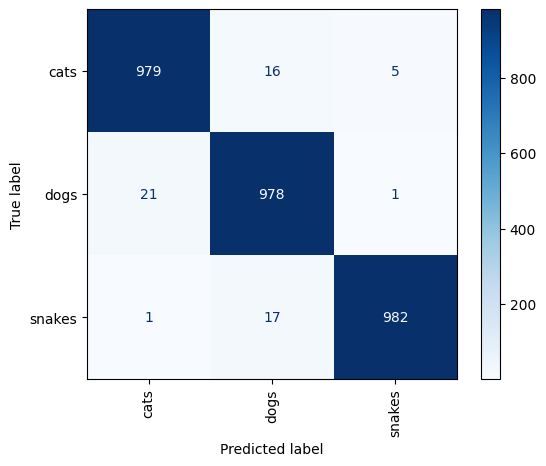

In [54]:
cm = confusion_matrix(real_val, predictions.cpu())

disp = ConfusionMatrixDisplay(cm, display_labels = image_dataset.classes)

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show();

In [55]:
def calculate_metrics(predictions, targets, num_classes):
    """
    Calculates accuracy, precision, and recall for a multi-class classification task.

    Args:
        predictions (torch.Tensor): Tensor of model predictions (logits or probabilities),
                                    shape (batch_size, num_classes).
        targets (torch.Tensor): Tensor of true labels, shape (batch_size,).
        num_classes (int): The total number of classes.

    Returns:
        tuple: (accuracy, precision (dict), recall (dict))
               - accuracy: Overall accuracy.
               - precision: Dictionary containing precision for each class.
               - recall: Dictionary containing recall for each class.
    """
    #preds = torch.argmax(predictions, dim=1)  # Get predicted class indices
    correct_predictions = (predictions == targets).sum().item()
    total_predictions = targets.size(0)
    accuracy = correct_predictions / total_predictions
    accuracy = round(accuracy, 2)

    precision = {}
    recall = {}

    for class_idx in range(num_classes):
        # True Positives: Predictions and targets are both the current class
        tp = ((predictions == class_idx) & (targets == class_idx)).sum().item()

        # False Positives: Predicted as the current class but the target is different
        fp = ((predictions == class_idx) & (targets != class_idx)).sum().item()

        # False Negatives: Target is the current class but the prediction is different
        fn = ((predictions != class_idx) & (targets == class_idx)).sum().item()

        # Calculate precision for the current class
        if tp + fp > 0:
            precision[class_idx] = tp / (tp + fp)
            precision[class_idx] = round(precision[class_idx], 2)

        else:
            precision[class_idx] = 0.0

        # Calculate recall for the current class
        if tp + fn > 0:
            recall[class_idx] = tp / (tp + fn)
            recall[class_idx] = round(recall[class_idx], 2)

        else:
            recall[class_idx] = 0.0

    return accuracy, precision, recall

In [58]:
num_classes = 3
predictions_tensor = predictions.clone().detach()
real_val_tensor = torch.tensor(real_val)
real_val_tensor = real_val_tensor.to(device)

accuracy, precision, recall = calculate_metrics(predictions_tensor, real_val_tensor, num_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.98
Precision: {0: 0.98, 1: 0.97, 2: 0.99}
Recall: {0: 0.98, 1: 0.98, 2: 0.98}


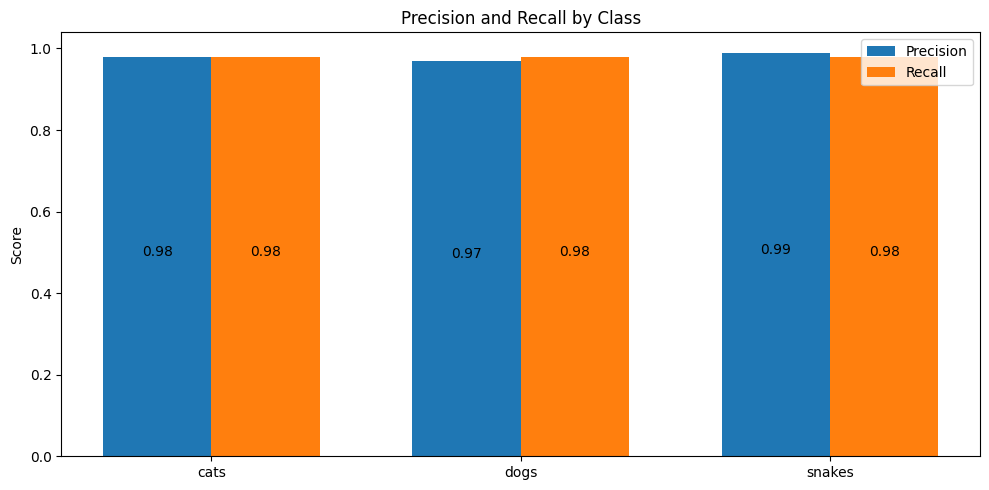

In [61]:
# Create a bar chart for precision and recall
#classes = list(precision.keys())
classes = image_dataset.classes
precision_values = list(precision.values())
recall_values = list(recall.values())

# Set up the plot
x = np.arange(len(classes))
width = 0.35  # the width of the b

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, precision_values, width, label='Precision')
rects2 = ax.bar(x + width/2, recall_values, width, label='Recall')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Score')
ax.set_title('Precision and Recall by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height/2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='center')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()